# Imports

In [1]:
import librosa
import librosa.display
import os
import glob
import pickle

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=26e20af12565638ef67c19c977312c579dfa8d7cdf28bc0c98538a76cd8d8be6
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [ ]:
import wave
import python_speech_features as ps

In [2]:
import itertools
import random
import numpy as np
import pandas as pd
import statistics 
import scipy.stats
import math

In [3]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Model, utils, initializers, losses, optimizers, Sequential, callbacks, backend
from keras.utils import conv_utils
import tensorflow.keras as K

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score as recall
from sklearn.metrics import confusion_matrix as confusion

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd '/content/drive/My Drive/BTP - Dev Priya and Kushagra/Speech Emotion Recognition/'

/content/drive/My Drive/BTP - Dev Priya and Kushagra/Speech Emotion Recognition


In [7]:
dataset_dir = 'Datasets/RAVDESS2'
ser_output_dir = 'Final Outputs/RAVDESS'

In [8]:
path_to_ravdess = '/content/drive/My Drive/BTP - Dev Priya and Kushagra/Licensed_Data/RAVDESS'

In [9]:
actor_list = []
for actor in sorted(os.listdir(path_to_ravdess)):
    actor_list.append(actor[-2:])
print(actor_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


In [10]:
speaker_list = []
for i in range(len(actor_list) // 3):
    speaker_list.append(actor_list[3*i:3*i+3])
print(speaker_list)

[['01', '02', '03'], ['04', '05', '06'], ['07', '08', '09'], ['10', '11', '12'], ['13', '14', '15'], ['16', '17', '18'], ['19', '20', '21'], ['22', '23', '24']]


# Preprocessing 

In [ ]:
class PreProcess:

    def __init__(self, root_dir, wav_files=None):
        self.eps = 1e-5
        self.filter_num = 40
        self.segment_length = 304
        self.num_per_emo = 1000
        self.root_dir = root_dir

        self.valid_actors = None
        self.test_actors = None
        self.output_file_name = None

        self.train_num = 0
        self.test_utterance_num = 0
        self.valid_utterance_num = 0
        self.test_segment_num = 0
        self.valid_segment_num = 0

        self.train_emt = {'hap': 0, 'ang': 0, 'neu': 0, 'sad': 0}
        self.test_emt = {'hap': 0, 'ang': 0, 'neu': 0, 'sad': 0}
        self.valid_emt = {'hap': 0, 'ang': 0, 'neu': 0, 'sad': 0}

        self.train_data = None
        self.test_data = None
        self.valid_data = None

        self.train_label = None
        self.test_label_utterance = None
        self.test_label_segment = None
        self.valid_label_utterance = None
        self.valid_label_segment = None

        self.test_segments_per_utterance = None
        self.valid_segments_per_utterance = None

        self.mean1, self.mean2, self.mean3 = 0, 0, 0
        self.std1, self.std2, self.std3 = 0, 0, 0

        self.wav_files = wav_files
        self.read_IEMOCAP()

    def get_spec_features(self, wav_filename):
        """Read the audio files in wav format and store the wave data"""
        wav_file = wave.open(wav_filename, 'r')
        params = wav_file.getparams()
        _, _, framerate, wav_length = params[:4]
        str_data = wav_file.readframes(wav_length)
        wave_data = np.frombuffer(str_data, dtype=np.short)
        wav_file.close()
        mel_spec = ps.logfbank(wave_data, framerate, nfilt=self.filter_num, nfft=1200)
        delta1 = ps.delta(mel_spec, 2)
        delta2 = ps.delta(delta1, 2)
        return mel_spec, delta1, delta2
    
    @staticmethod
    def generate_label(emotion):
        if emotion == 'ang':
            return 0
        elif emotion == 'sad':
            return 1
        elif emotion == 'hap':
            return 2
        elif emotion == 'neu':
            return 3
        elif emotion == 'fear':
            return 4
        return 5

    @staticmethod
    def get_emotion(filename):
        id = filename.split("-")[2]
        if id == "01":
            return "neu"
        elif id == "03":
            return "hap"
        elif id == "04":
            return "sad"
        elif id == "05":
            return "ang"
        return None
    
    def read_IEMOCAP(self):
        """Read the data files and generate a dict with generated features"""
        if self.wav_files is not None:
            return
        self.wav_files = {}
        for actor in sorted(os.listdir(self.root_dir)):
            if actor[0] != 'A':
                continue
            wav_dir = os.path.join(self.root_dir, actor)
            for filename in sorted(os.listdir(wav_dir)):
                wav_name = os.path.basename(filename)
                wav_name = os.path.splitext(wav_name)[0]
                filename = os.path.join(wav_dir, filename)
                emotion = self.get_emotion(wav_name)
                if emotion is None:
                    continue
                mel_spec, delta1, delta2 = self.get_spec_features(filename)
                self.wav_files[wav_name] = {
                    'emotion': emotion,
                    'mel_spec': mel_spec,
                    'path': filename,
                    'delta1': delta1,
                    'delta2': delta2
                }
            print(actor)
        # print(self.wav_files)

    def update_count(self, emotion, set_type):
        if set_type == 'train':
            self.train_emt[emotion] += 1
            self.train_num += 1
        elif set_type == 'test':
            self.test_emt[emotion] += 1
            self.test_segment_num += 1
        else:
            self.valid_emt[emotion] += 1
            self.valid_segment_num += 1

    def initialize(self):
        self.train_data = np.empty((self.train_num, self.segment_length, self.filter_num, 3), dtype=np.float32)
        self.test_data = np.empty((self.test_segment_num, self.segment_length, self.filter_num, 3), dtype=np.float32)
        self.valid_data = np.empty((self.valid_segment_num, self.segment_length, self.filter_num, 3), dtype=np.float32)

        self.train_label = np.empty((self.train_num, 1), dtype=np.int8)
        self.test_label_segment = np.empty((self.test_segment_num, 1), dtype=np.int8)
        self.valid_label_segment = np.empty((self.valid_segment_num, 1), dtype=np.int8)
        self.test_label_utterance = np.empty((self.test_utterance_num, 1), dtype=np.int8)
        self.valid_label_utterance = np.empty((self.valid_utterance_num, 1), dtype=np.int8)

        self.test_segments_per_utterance = np.zeros((self.test_utterance_num, 1), dtype=np.int8)
        self.valid_segments_per_utterance = np.zeros((self.valid_utterance_num, 1), dtype=np.int8)

        self.train_num = 0
        self.test_segment_num = 0
        self.valid_segment_num = 0
        self.test_utterance_num = 0
        self.valid_utterance_num = 0

    def count_data(self):
        self.train_num = 0
        self.test_utterance_num = 0
        self.valid_utterance_num = 0
        self.test_segment_num = 0
        self.valid_segment_num = 0

        self.train_emt = {'hap': 0, 'ang': 0, 'neu': 0, 'sad': 0}
        self.test_emt = {'hap': 0, 'ang': 0, 'neu': 0, 'sad': 0}
        self.valid_emt = {'hap': 0, 'ang': 0, 'neu': 0, 'sad': 0}

        for wav_name in sorted(self.wav_files.keys()):
            time = self.wav_files[wav_name]['mel_spec'].shape[0]
            emotion = self.wav_files[wav_name]['emotion']
            set_type = self.find_set(wav_name)  # train/test/validation

            if time < self.segment_length:
                start_times = [0] #padding
            elif set_type == "train" and emotion == "neu":
                start_times = [0, 0, time - self.segment_length, time - self.segment_length]
            else:
                start_times = [0, time - self.segment_length]

            end_times = [i + self.segment_length for i in start_times]

            for begin, end in zip(start_times, end_times):
                self.update_count(emotion, set_type)
            if set_type == 'validation':
                self.valid_utterance_num += 1
            if set_type == 'test':
                self.test_utterance_num += 1

        self.num_per_emo = min(self.train_emt['hap'], self.train_emt['ang'],
                               self.train_emt['neu'], self.train_emt['sad'])
        print(self.train_emt)
        print(self.num_per_emo)

    def add_to_set(self, part, delta11, delta21, emotion, set_type):
        # TODO extend it for test validation
        if set_type == 'train':
            self.train_data[self.train_num, :, :, 0] = part.copy()
            self.train_data[self.train_num, :, :, 1] = delta11.copy()
            self.train_data[self.train_num, :, :, 2] = delta21.copy()
            self.train_label[self.train_num] = emotion
            self.train_num += 1
        elif set_type == 'test':
            self.test_data[self.test_segment_num, :, :, 0] = part.copy()
            self.test_data[self.test_segment_num, :, :, 1] = delta11.copy()
            self.test_data[self.test_segment_num, :, :, 2] = delta21.copy()
            self.test_label_segment[self.test_segment_num] = emotion
            self.test_segments_per_utterance[self.test_utterance_num] += 1
            self.test_segment_num += 1
        else:
            self.valid_data[self.valid_segment_num, :, :, 0] = part.copy()
            self.valid_data[self.valid_segment_num, :, :, 1] = delta11.copy()
            self.valid_data[self.valid_segment_num, :, :, 2] = delta21.copy()
            self.valid_label_segment[self.valid_segment_num] = emotion
            self.valid_segments_per_utterance[self.valid_utterance_num] += 1
            self.valid_segment_num += 1
        # print('\t'.join((str(train_num), wavname, '0', 'self.frame_num', emotion)))

    def find_set(self, wav_name):
        """returns whether the wav_name should be part of train/test/validation set"""
        if wav_name[-2:] in self.valid_actors:
            return 'validation'
        if wav_name[-2:] in self.test_actors:
            return 'test'
        return 'train'

    def data_padding(self, data):
        """Padding short segments of data with 0s"""
        return np.pad(data, ((0, self.segment_length - data.shape[0]), (0, 0)), 'constant', constant_values=0)

    def generate_data(self):
        """generates train test validation sets before calculating zscore """
        for wav_name in sorted(self.wav_files.keys()):
            part = self.wav_files[wav_name]['mel_spec']
            delta11 = self.wav_files[wav_name]['delta1']
            delta21 = self.wav_files[wav_name]['delta2']
            emotion = self.wav_files[wav_name]['emotion']
            filename = self.wav_files[wav_name]['path']
            
            time = part.shape[0]

            set_type = self.find_set(wav_name)  # train/test/validation
            

            if time < self.segment_length:
                part = self.data_padding(part)
                delta11 = self.data_padding(delta11)
                delta21 = self.data_padding(delta21)
                start_times = [0] #padding
            elif set_type == "train" and emotion == "neu":
                start_times = [0, 0, time - self.segment_length, time - self.segment_length]
            else:
                start_times = [0, time - self.segment_length]
            
            end_times = [i + self.segment_length for i in start_times]

            emotion = self.generate_label(emotion)
            for begin, end in zip(start_times, end_times):
                try:
                    self.add_to_set(part[begin:end, :], delta11[begin:end, :], delta21[begin:end, :], emotion, set_type)
                except:
                    print([begin, end])
                    print(start_times)

            if set_type == 'validation':
                self.valid_label_utterance[self.valid_utterance_num] = emotion
                self.valid_utterance_num += 1
            if set_type == 'test':
                self.test_label_utterance[self.test_utterance_num] = emotion
                self.test_utterance_num += 1

    def class_indices(self):
        """"Index of each emotion class instance in the training data"""
        hap_index = np.arange(self.train_emt['hap'])
        neu_index = np.arange(self.train_emt['neu'])
        sad_index = np.arange(self.train_emt['sad'])
        ang_index = np.arange(self.train_emt['ang'])
        h2 = 0
        a0 = 0
        n3 = 0
        s1 = 0
        for i in range(self.train_num):
            if self.train_label[i] == 0:
                ang_index[a0] = i
                a0 = a0 + 1
            elif self.train_label[i] == 1:
                sad_index[s1] = i
                s1 = s1 + 1
            elif self.train_label[i] == 2:
                hap_index[h2] = i
                h2 = h2 + 1
            else:
                neu_index[n3] = i
                n3 = n3 + 1
        return hap_index, sad_index, neu_index, ang_index
    
    def balance_training_data(self):
        hap_index, sad_index, neu_index, ang_index = self.class_indices()
        np.random.seed(0)
        np.random.shuffle(neu_index)
        np.random.seed(0)
        np.random.shuffle(hap_index)
        np.random.seed(0)
        np.random.shuffle(sad_index)
        np.random.seed(0)
        np.random.shuffle(ang_index)

        self.train_num = 4 * self.num_per_emo
        train_label = np.empty((self.train_num, 1), dtype=np.int8)
        train_data = np.empty((4 * self.num_per_emo, self.segment_length, self.filter_num, 3), dtype=np.float32)

        train_data[0:self.num_per_emo] = self.train_data[hap_index[0:self.num_per_emo]].copy()
        train_label[0:self.num_per_emo] = self.train_label[hap_index[0:self.num_per_emo]].copy()

        train_data[self.num_per_emo:2 * self.num_per_emo] = self.train_data[sad_index[0:self.num_per_emo]].copy()
        train_label[self.num_per_emo:2 * self.num_per_emo] = self.train_label[sad_index[0:self.num_per_emo]].copy()
        
        train_data[2 * self.num_per_emo:3 * self.num_per_emo] = self.train_data[neu_index[0:self.num_per_emo]].copy()
        train_label[2 * self.num_per_emo:3 * self.num_per_emo] = self.train_label[neu_index[0:self.num_per_emo]].copy()
        
        train_data[3 * self.num_per_emo:4 * self.num_per_emo] = self.train_data[ang_index[0:self.num_per_emo]].copy()
        train_label[3 * self.num_per_emo:4 * self.num_per_emo] = self.train_label[ang_index[0:self.num_per_emo]].copy()
        
        arr = np.arange(4 * self.num_per_emo)
        np.random.seed(0)
        np.random.shuffle(arr)
        self.train_data = train_data[arr[0:]]
        self.train_label = train_label[arr[0:]]
        
    
    def calculate_zscore(self):
        """calculates zscore from train data """
        self.mean1 = np.mean(self.train_data[:, :, :, 0].reshape(self.train_num * self.segment_length, self.filter_num),
                             axis=0)
        self.mean2 = np.mean(self.train_data[:, :, :, 1].reshape(self.train_num * self.segment_length, self.filter_num),
                             axis=0)
        self.mean3 = np.mean(self.train_data[:, :, :, 2].reshape(self.train_num * self.segment_length, self.filter_num),
                             axis=0)
        self.std1 = np.std(self.train_data[:, :, :, 0].reshape(self.train_num * self.segment_length, self.filter_num),
                           axis=0)
        self.std2 = np.std(self.train_data[:, :, :, 1].reshape(self.train_num * self.segment_length, self.filter_num),
                           axis=0)
        self.std3 = np.std(self.train_data[:, :, :, 2].reshape(self.train_num * self.segment_length, self.filter_num),
                           axis=0)

    def standardize_data(self):
        """Standardize train test validation sets after the calculation of zscore"""
        for i in range(self.train_num):
            self.train_data[i, :, :, 0] = (self.train_data[i, :, :, 0] - self.mean1) / (self.std1 + self.eps)
            self.train_data[i, :, :, 1] = (self.train_data[i, :, :, 1] - self.mean2) / (self.std2 + self.eps)
            self.train_data[i, :, :, 2] = (self.train_data[i, :, :, 2] - self.mean3) / (self.std3 + self.eps)

        for i in range(self.test_segment_num):
            self.test_data[i, :, :, 0] = (self.test_data[i, :, :, 0] - self.mean1) / (self.std1 + self.eps)
            self.test_data[i, :, :, 1] = (self.test_data[i, :, :, 1] - self.mean2) / (self.std2 + self.eps)
            self.test_data[i, :, :, 2] = (self.test_data[i, :, :, 2] - self.mean3) / (self.std3 + self.eps)

        for i in range(self.valid_segment_num):
            self.valid_data[i, :, :, 0] = (self.valid_data[i, :, :, 0] - self.mean1) / (self.std1 + self.eps)
            self.valid_data[i, :, :, 1] = (self.valid_data[i, :, :, 1] - self.mean2) / (self.std2 + self.eps)
            self.valid_data[i, :, :, 2] = (self.valid_data[i, :, :, 2] - self.mean3) / (self.std3 + self.eps)

    def preprocess(self, output_file_name, test_actors, valid_actors):
        """Process the audio files to generate train/test/validation data with extracted features"""
        # self.read_IEMOCAP()
        self.valid_actors = valid_actors
        self.test_actors = test_actors
        self.output_file_name = output_file_name

        self.count_data()
        self.initialize()
        self.generate_data()
        self.balance_training_data()
        self.calculate_zscore()
        self.standardize_data()

        f = open(self.output_file_name, 'wb')
        pickle.dump((
            self.train_data, self.train_label,
            self.test_data, self.test_label_utterance, self.test_label_segment, self.test_segments_per_utterance,
            self.valid_data, self.valid_label_utterance, self.valid_label_segment, self.valid_segments_per_utterance),
            f)
        f.close()

In [ ]:
dataset_dir = 'Datasets/RAVDESS2'

In [ ]:
p = PreProcess(path_to_ravdess, wav_files)

In [ ]:
print(len(p.wav_files))

675


In [ ]:
wav_files = p.wav_files

In [ ]:
for i in range(len(speaker_list)):
    test_actors = speaker_list[i]
    valid_actors = speaker_list[i-1][1:]
    output_file_name = dataset_dir + '/data_' + 'Valid_' + ("_").join(valid_actors) + '_Test_' + ("_").join(test_actors) + '.pkl'
    print(output_file_name)
    p.preprocess(output_file_name, test_actors, valid_actors)

Datasets/RAVDESS2/data_Valid_23_24_Test_01_02_03.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304
Datasets/RAVDESS2/data_Valid_02_03_Test_04_05_06.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304
Datasets/RAVDESS2/data_Valid_05_06_Test_07_08_09.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304
Datasets/RAVDESS2/data_Valid_08_09_Test_10_11_12.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304
Datasets/RAVDESS2/data_Valid_11_12_Test_13_14_15.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304
Datasets/RAVDESS2/data_Valid_14_15_Test_16_17_18.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304
Datasets/RAVDESS2/data_Valid_17_18_Test_19_20_21.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304
Datasets/RAVDESS2/data_Valid_20_21_Test_22_23_24.pkl
{'hap': 304, 'ang': 304, 'neu': 304, 'sad': 310}
304


# Model

## Custom Layer

In [11]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        self.hidden_size = kwargs.pop('hidden_size')
        super(CustomAttention, self).__init__(*args, **kwargs)
        self.W_omega = tf.Variable(
            initializers.GlorotNormal(seed=0)(shape=[self.hidden_size, 1]), 
            dtype=tf.float32,
            trainable=True,
            name="W_omega")
        self.b_omega = tf.Variable(
            initializers.GlorotNormal(seed=0)(shape=[1]), 
            dtype=tf.float32,
            trainable=True,
            name="b_omega")
        self.u_omega = tf.Variable(
            initializers.GlorotNormal(seed=0)(shape=[1]), 
            dtype=tf.float32,
            trainable=True,
            name="u_omega")
    
    def call(self, inputs, **kwargs):
        v = tf.sigmoid(tf.tensordot(inputs, self.W_omega, axes=1) + self.b_omega)
        vu = tf.tensordot(v, self.u_omega, axes=1)
        alphas = layers.Softmax()(vu)
        return tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
        
    def get_config(self):
        config = ({
            'hidden_size': self.hidden_size 
        })
        base_config = super(CustomAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Build Model

### Fishnet 6.0
Trying to implement arch from paper itself

In [ ]:
hparams = {
'OUT_CHANNELS' : [128, 256],
'FILTER_CONV1' : 128,
'KERNEL_CONV1' : (3, 3),
'STRIDE_CONV1' : (1, 1),
'BIAS_INIT' : 'ones',
'KERNEL_INIT' : 'glorot_normal',
'PADDING_CONV' : 'SAME',
'BN_MOMENTUM' : 0.99,
'LEAKY_ALPHA' : 0.3,
'SIZE_POOL_CONV1' : (2, 4),
'PADDING_POOL_CONV1' : 'VALID',
'NUM_DIL_LAYERS' : 3,
'FILTER_CONV_UFLB' : 128,
'KERNEL_CONV_UFLB' :  (3, 3),
'STRIDE_CONV_UFLB' : (1, 1),
'DIL_RATE_CONV_UFLB' : (2, 2),
'PADDING_CONV_UFLB' : 'SAME',
'BILSTM_UNITS_SPEC' : 256,
'UNITS_FCN' : [512, 256, 64],
'LR' : 0.00001,
}

bottleneck function source: https://github.com/kevin-ssy/FishNet/blob/master/models/fish_block.py

In [ ]:
def bottleneck(input, filters, mode="NORM", kernel_size=(3, 3), strides=(1, 1), dilation_rate=(1, 1)):
    inplanes = input.shape[-1]
    btnk_filters = filters // 4

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(input)
    x = layers.Conv2D(filters=btnk_filters, kernel_size=(1, 1),
                      strides=(1, 1), dilation_rate=(1, 1), 
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x)
    x = layers.Conv2D(filters=btnk_filters, kernel_size=kernel_size,
                      strides=strides, dilation_rate=dilation_rate, 
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x)
    x = layers.Conv2D(filters=filters, kernel_size=(1, 1),
                      strides=(1, 1), dilation_rate=(1, 1), 
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)

    if mode == "UP":
        y = None    #shortcut
    elif inplanes != filters or strides != (1, 1):
        y = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(input)
        y = layers.Conv2D(filters=filters, kernel_size=(1, 1),
                          strides=strides, dilation_rate=(1, 1), 
                          bias_initializer=hparams['BIAS_INIT'],
                          kernel_initializer=hparams['KERNEL_INIT'],
                          padding=hparams['PADDING_CONV'])(y)
        y = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(y)
    else:
        y = None

    return x, y


channelwise_reduction, ur_block, dr_block, se_block source: paper

In [ ]:
# @tf.function
def channelwise_reduction(x, k):
    cin = x.shape[-1]
    cout = cin // k
    y = tf.reshape(x, [-1, x.shape[1], x.shape[2], cout, k])
    y = tf.reduce_sum(y, -1)
    return y

In [ ]:
def ur_block(input, k=4, pool_size=(2, 2), kernel_size=(3, 3), strides=(1, 1), dilation_rate=(1, 1)):
    # input = layers.concatenate([input, residual])
    units = input.shape[-1]
    mx, _ = bottleneck(input, units // k, "UP", kernel_size, strides, dilation_rate)
    rx = channelwise_reduction(input, k)
    input = layers.Add()([mx, rx])
    input = layers.UpSampling2D(size=pool_size)(input)
    return input

In [ ]:
def dr_block(input, k=1, pool_size=(2, 2), kernel_size=(3, 3), strides=(1, 1), dilation_rate=(1, 1)):
    # input = layers.concatenate([input, residual])
    units = input.shape[-1]
    mx, y = bottleneck(input, units // k, "NORM", kernel_size, strides, dilation_rate)
    if y != None:
        input = layers.Add()([mx, y])
    else:
        input = layers.Add()([mx, input])
    input = layers.MaxPool2D(pool_size=pool_size)(input)
    return input

In [ ]:
def se_block(input, transform_fn=None, r=8):
    if transform_fn is not None:
        input = transform_fn(input)
    y = layers.GlobalAveragePooling2D()(input)
    units = y.shape[-1]
    y = layers.Dense(units=units // r, activation="linear")(y)
    y = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(y)
    y = layers.Dense(units=units, activation="sigmoid")(y) # Sigmoid activation
    input = tf.transpose(input, perm=[1,2,0,3])
    input = tf.math.multiply(input, y)
    input = tf.transpose(input, perm=[2,0,1,3])
    return input

In [ ]:
input_shape = (304, 40, 3)

In [ ]:
def conv_block(input, out_channels, kernel_size=(5, 3), strides=(1, 1)):
    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(input)
    x = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, 
                      strides=strides,
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV_UFLB'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)
    return x

In [ ]:
def build_model():
    model_input_spec = Input(shape=input_shape, name='spec_features')
    x = conv_block(model_input_spec, hparams['OUT_CHANNELS'][0])
    x = conv_block(x, hparams['OUT_CHANNELS'][1])
    ############################# TAIL ######################################## 
    
    x = dr_block(x)
    t1 = x
    print(('t1', x.shape))

    x = dr_block(x)
    t2 = x
    print(('t2', x.shape))

    x = dr_block(x)
    t3 = x
    print(('t3', x.shape))

    x = dr_block(x, k=2, pool_size=(2, 1))
    t4 = x
    print(('t4', x.shape))
   
    x = se_block(x) # W x H x C3
    ############################# BODY ######################################## 
    
    x = ur_block(x, pool_size=(2, 1))
    x = layers.concatenate([t3, x]) # W x H x C2+C3
    b1 = x
    print(('b1', x.shape))

    x = ur_block(x, k=6) # 2W x 2H x (C2+C3)/k
    x = layers.concatenate([t2, x]) # 2W x 2H x C1+(C2+C3)/k
    b2 = x
    print(('b2', x.shape))

    x = ur_block(x) # 2W x 2H x (C2+C3)/k
    x = layers.concatenate([t1, x]) # 2W x 2H x C1+(C2+C3)/k
    b3 = x
    print(('b3', x.shape))

    ############################# HEAD ########################################
    x = dr_block(x, k=2)
    x = layers.concatenate([b2, x]) 
    print(('h1', x.shape))
    
    x = dr_block(x, k=4) 
    x = layers.concatenate([b1, x]) 
    print(('h2', x.shape))

    x = dr_block(x, k=2, pool_size=(2, 1)) 
    x = layers.concatenate([t4, x]) 
    print(('h3', x.shape))

    #############################################################################

    time_step = x.shape[1]
    linear_units = x.shape[2]*x.shape[3]
    x = tf.reshape(x,[-1,time_step,linear_units])


    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'],
                             name='LEAKY_LINEAR')(x)
    x = layers.Bidirectional(layers.GRU(units=hparams['BILSTM_UNITS_SPEC'],
                                         bias_initializer=hparams['BIAS_INIT'],
                                         kernel_initializer=hparams['KERNEL_INIT'], 
                                         return_sequences=True))(x)
    x = CustomAttention(hidden_size=x.shape[2])(x)

    for i, n in enumerate(hparams['UNITS_FCN']):
        x = layers.Dense(units=n, activation="linear", 
                         name='fcn_dense'+str(i+1))(x)
        x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'], 
                             name='fcn_leaky'+str(i+1))(x)
    
    x = layers.Dense(units=4, activation="softmax", name='Softmax')(x)

    model = Model(inputs=model_input_spec, outputs=x, name="model_adrnn") 

    model.compile(
        loss=losses.CategoricalCrossentropy(from_logits=False),
        optimizer=optimizers.Adam(
            learning_rate=hparams['LR']
        ),
        metrics=['categorical_accuracy'],
    )
    print(model.summary())

    return model

('t1', TensorShape([None, 152, 20, 256]))
('t2', TensorShape([None, 76, 10, 256]))
('t3', TensorShape([None, 38, 5, 256]))
('t4', TensorShape([None, 19, 5, 128]))
('b1', TensorShape([None, 38, 5, 288]))
('b2', TensorShape([None, 76, 10, 304]))
('b3', TensorShape([None, 152, 20, 332]))
('h1', TensorShape([None, 76, 10, 470]))
('h2', TensorShape([None, 38, 5, 405]))
('h3', TensorShape([None, 19, 5, 330]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_371 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
_____________________________________________________________________________

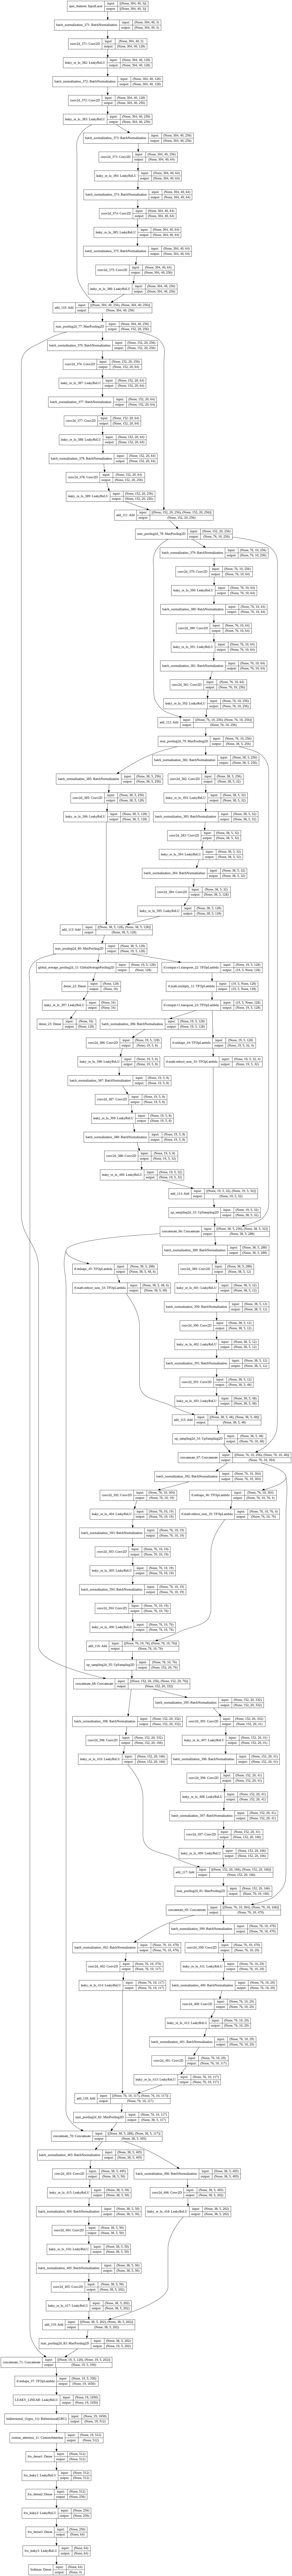

In [ ]:
model = build_model()
utils.plot_model(model, show_shapes=True)

### Fishnet 7.0
Trying to implement arch from paper itself

In [12]:
hparams = {
'OUT_CHANNELS' : [128],
'FILTER_CONV1' : 128,
'KERNEL_CONV1' : (3, 3),
'STRIDE_CONV1' : (1, 1),
'BIAS_INIT' : 'ones',
'KERNEL_INIT' : 'glorot_normal',
'PADDING_CONV' : 'SAME',
'BN_MOMENTUM' : 0.99,
'LEAKY_ALPHA' : 0.3,
'SIZE_POOL_CONV1' : (2, 4),
'PADDING_POOL_CONV1' : 'VALID',
'NUM_DIL_LAYERS' : 3,
'FILTER_CONV_UFLB' : 128,
'KERNEL_CONV_UFLB' :  (3, 3),
'STRIDE_CONV_UFLB' : (1, 1),
'DIL_RATE_CONV_UFLB' : (2, 2),
'PADDING_CONV_UFLB' : 'SAME',
'BILSTM_UNITS_SPEC' : 256,
'UNITS_FCN' : [512, 256, 64],
'LR' : 0.00001,
}

bottleneck function source: https://github.com/kevin-ssy/FishNet/blob/master/models/fish_block.py

In [13]:
def bottleneck(input, filters, mode="NORM", kernel_size=(3, 3), strides=(1, 1), dilation_rate=(1, 1)):
    inplanes = input.shape[-1]
    btnk_filters = filters // 4

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(input)
    x = layers.Conv2D(filters=btnk_filters, kernel_size=(3, 3),
                      strides=(1, 1), dilation_rate=(1, 1), 
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x)
    x = layers.Conv2D(filters=btnk_filters, kernel_size=kernel_size,
                      strides=strides, dilation_rate=dilation_rate, 
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)

    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(x)
    x = layers.Conv2D(filters=filters, kernel_size=(3, 3),
                      strides=(1, 1), dilation_rate=(1, 1), 
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)

    if mode == "UP":
        y = None    #shortcut
    elif inplanes != filters or strides != (1, 1):
        y = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(input)
        y = layers.Conv2D(filters=filters, kernel_size=(3, 3),
                          strides=strides, dilation_rate=(1, 1), 
                          bias_initializer=hparams['BIAS_INIT'],
                          kernel_initializer=hparams['KERNEL_INIT'],
                          padding=hparams['PADDING_CONV'])(y)
        y = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(y)
    else:
        y = None

    return x, y


channelwise_reduction, ur_block, dr_block, se_block source: paper

In [14]:
# @tf.function
def channelwise_reduction(x, k):
    cin = x.shape[-1]
    cout = cin // k
    y = tf.reshape(x, [-1, x.shape[1], x.shape[2], cout, k])
    y = tf.reduce_sum(y, -1)
    return y

In [15]:
def ur_block(input, k=4, pool_size=(2, 2), kernel_size=(5, 3), strides=(1, 1), dilation_rate=(1, 1)):
    # input = layers.concatenate([input, residual])
    units = input.shape[-1]
    mx, _ = bottleneck(input, units // k, "UP", kernel_size, strides, dilation_rate)
    rx = channelwise_reduction(input, k)
    input = layers.Add()([mx, rx])
    input = layers.UpSampling2D(size=pool_size)(input)
    return input

In [16]:
def dr_block(input, k=1, pool_size=(2, 2), kernel_size=(5, 3), strides=(1, 1), dilation_rate=(1, 1)):
    # input = layers.concatenate([input, residual])
    units = input.shape[-1]
    mx, y = bottleneck(input, units // k, "NORM", kernel_size, strides, dilation_rate)
    if y != None:
        input = layers.Add()([mx, y])
    else:
        input = layers.Add()([mx, input])
    input = layers.MaxPool2D(pool_size=pool_size)(input)
    return input

In [17]:
def se_block(input, transform_fn=None, r=8):
    if transform_fn is not None:
        input = transform_fn(input)
    y = layers.GlobalAveragePooling2D()(input)
    units = y.shape[-1]
    y = layers.Dense(units=units // r, activation="linear")(y)
    y = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(y)
    y = layers.Dense(units=units, activation="sigmoid")(y) # Sigmoid activation
    input = tf.transpose(input, perm=[1,2,0,3])
    input = tf.math.multiply(input, y)
    input = tf.transpose(input, perm=[2,0,1,3])
    return input

In [18]:
input_shape = (304, 40, 3)

In [19]:
def conv_block(input, out_channels, kernel_size=(5, 3), strides=(1, 1)):
    x = layers.BatchNormalization(momentum=hparams['BN_MOMENTUM'])(input)
    x = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, 
                      strides=strides,
                      bias_initializer=hparams['BIAS_INIT'],
                      kernel_initializer=hparams['KERNEL_INIT'],
                      padding=hparams['PADDING_CONV_UFLB'])(x)
    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'])(x)
    return x

In [20]:
def build_model():
    model_input_spec = Input(shape=input_shape, name='spec_features')
    x = conv_block(model_input_spec, hparams['OUT_CHANNELS'][0])
    ############################# TAIL ########################################     
    x = dr_block(x, pool_size=(2, 1))
    t1 = x
    print(('t1', x.shape))

    x = dr_block(x, pool_size=(1, 2))
    t2 = x
    print(('t2', x.shape))

    x = dr_block(x, k=2, pool_size=(1, 2))
    t3 = x
    print(('t3', x.shape))

    x = dr_block(x, pool_size=(2, 1))
    t4 = x
    print(('t4', x.shape))
   
    x = se_block(x) # W x H x C3
    ############################# BODY ######################################## 
    
    x = ur_block(x, pool_size=(2, 1))
    x = layers.concatenate([t3, x]) # W x H x C2+C3
    b1 = x
    print(('b1', x.shape))

    x = ur_block(x, pool_size=(1, 2)) # 2W x 2H x (C2+C3)/k
    x = layers.concatenate([t2, x]) # 2W x 2H x C1+(C2+C3)/k
    b2 = x
    print(('b2', x.shape))

    x = ur_block(x, pool_size=(1, 2)) # 2W x 2H x (C2+C3)/k
    x = layers.concatenate([t1, x]) # 2W x 2H x C1+(C2+C3)/k
    b3 = x
    print(('b3', x.shape))

    ############################# HEAD ########################################
    x = dr_block(x, k=2, pool_size=(1, 2))
    x = layers.concatenate([b2, x]) 
    print(('h1', x.shape))
    
    x = dr_block(x, k=2, pool_size=(1, 2)) 
    x = layers.concatenate([b1, x]) 
    print(('h2', x.shape))

    x = dr_block(x, k=2, pool_size=(2, 1)) 
    x = layers.concatenate([t4, x]) 
    print(('h3', x.shape))

    #############################################################################

    time_step = x.shape[1]
    linear_units = x.shape[2]*x.shape[3]
    x = tf.reshape(x,[-1,time_step,linear_units])


    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'],
                             name='LEAKY_LINEAR')(x)
    x = layers.Bidirectional(layers.GRU(units=hparams['BILSTM_UNITS_SPEC'],
                                         bias_initializer=hparams['BIAS_INIT'],
                                         kernel_initializer=hparams['KERNEL_INIT'], 
                                         return_sequences=True))(x)
    x = CustomAttention(hidden_size=x.shape[2])(x)

    for i, n in enumerate(hparams['UNITS_FCN']):
        x = layers.Dense(units=n, activation="linear", 
                         name='fcn_dense'+str(i+1))(x)
        x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'], 
                             name='fcn_leaky'+str(i+1))(x)
    
    x = layers.Dense(units=4, activation="softmax", name='Softmax')(x)

    model = Model(inputs=model_input_spec, outputs=x, name="model_adrnn") 

    model.compile(
        loss=losses.CategoricalCrossentropy(from_logits=False),
        optimizer=optimizers.Adam(
            learning_rate=hparams['LR']
        ),
        metrics=['categorical_accuracy'],
    )
    print(model.summary())

    return model

In [21]:
model = build_model()
utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def build_model():
    model_input_spec = Input(shape=input_shape, name='spec_features')
    x = conv_block(model_input_spec, hparams['OUT_CHANNELS'][0])
    ############################# TAIL ########################################     
    x = dr_block(x, pool_size=(2, 1))
    t1 = x
    print(('t1', x.shape))

    x = dr_block(x, k=2, pool_size=(1, 2))
    t2 = x
    print(('t2', x.shape))

    x = dr_block(x, pool_size=(1, 2))
    t3 = x
    print(('t3', x.shape))
   
    x = se_block(x) # W x H x C3
    ############################# BODY ######################################## 

    x = ur_block(x, k=2, pool_size=(1, 2)) # 2W x 2H x (C2+C3)/k
    x = layers.concatenate([t2, x]) # 2W x 2H x C1+(C2+C3)/k
    b1 = x
    print(('b1', x.shape))

    x = ur_block(x, k=3, pool_size=(1, 2)) # 2W x 2H x (C2+C3)/k
    x = layers.concatenate([t1, x]) # 2W x 2H x C1+(C2+C3)/k
    b2 = x
    print(('b2', x.shape))

    ############################# HEAD ########################################
    x = dr_block(x, k=2, pool_size=(1, 2))
    x = layers.concatenate([b1, x]) 
    print(('h1', x.shape))
    
    x = dr_block(x, k=2, pool_size=(1, 2)) 
    x = layers.concatenate([t3, x]) 
    print(('h2', x.shape))

    #############################################################################

    time_step = x.shape[1]
    linear_units = x.shape[2]*x.shape[3]
    x = tf.reshape(x,[-1,time_step,linear_units])


    x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'],
                             name='LEAKY_LINEAR')(x)
    x = layers.Bidirectional(layers.GRU(units=hparams['BILSTM_UNITS_SPEC'],
                                         bias_initializer=hparams['BIAS_INIT'],
                                         kernel_initializer=hparams['KERNEL_INIT'], 
                                         return_sequences=True))(x)
    x = CustomAttention(hidden_size=x.shape[2])(x)

    for i, n in enumerate(hparams['UNITS_FCN']):
        x = layers.Dense(units=n, activation="linear", 
                         name='fcn_dense'+str(i+1))(x)
        x = layers.LeakyReLU(alpha=hparams['LEAKY_ALPHA'], 
                             name='fcn_leaky'+str(i+1))(x)
    
    x = layers.Dense(units=4, activation="softmax", name='Softmax')(x)

    model = Model(inputs=model_input_spec, outputs=x, name="model_adrnn") 

    model.compile(
        loss=losses.CategoricalCrossentropy(from_logits=False),
        optimizer=optimizers.Adam(
            learning_rate=hparams['LR']
        ),
        metrics=['categorical_accuracy'],
    )
    print(model.summary())

    return model

In [ ]:
model = build_model()
# utils.plot_model(model, show_shapes=True)

('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 304, 40, 128) 5888        batch_normalization[0][0]    

# Retrieve Data

In [22]:
def retrieve_preprocessed_data():
    test_actors = speaker_list[idx]
    valid_actors = speaker_list[idx-1][1:]
    file_code = '_Valid_' + ("_").join(valid_actors) + '_Test_' + ("_").join(test_actors) 
    data_file_name = dataset_dir + '/data' + file_code + '.pkl'
    print(data_file_name)

    f = open(data_file_name, 'rb')
    output = pickle.load(f)
    train_features, train_labels = output[0], output[1]  
    test_features, test_labels, test_segments_per_utterance = output[2], output[3], output[5]
    valid_features, valid_labels, valid_segments_per_utterance = output[6], output[7], output[9]  
    f.close()

    train_features = tf.convert_to_tensor(train_features, dtype=tf.float32)
    valid_features = tf.convert_to_tensor(valid_features, dtype=tf.float32)
    test_features = tf.convert_to_tensor(test_features, dtype=tf.float32)

    train_labels = tf.one_hot(train_labels, 4, dtype=tf.float32)
    valid_labels = tf.one_hot(valid_labels, 4, dtype=tf.float32)
    test_labels = tf.one_hot(test_labels, 4, dtype=tf.float32)

    train_labels = tf.reshape(train_labels, [train_labels.shape[0], 4])
    valid_labels = tf.reshape(valid_labels, [valid_labels.shape[0], 4])
    test_labels = tf.reshape(test_labels, [test_labels.shape[0], 4])

    return train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance

In [23]:
def save_results(test_accuracy, test_conf):
    if not os.path.exists(ser_output_dir):
        os.mkdir(ser_output_dir)
    dir = os.path.join(ser_output_dir, 'Run_'+ str(run))
    if not os.path.exists(dir):
        os.mkdir(dir)
    test_actors = speaker_list[idx]
    valid_actors = speaker_list[idx-1][1:]
    file_code = 'Valid_' + ("_").join(valid_actors) + '_Test_' + ("_").join(test_actors) 
    data_file_name = dir + '/' + file_code + '.pkl'
    print(data_file_name)
    f = open(data_file_name, 'wb')
    pickle.dump((test_accuracy, test_conf), f)
    f.close()

# Train and Evaulate

In [24]:
def train_and_evaluate(model, num_epochs=1200):
    i=0
    best_valid_accuracy = 0
    best_epoch = 0

    while i< num_epochs:
        start = (i*60)%train_features.shape[0]
        end = min(start+60, train_features.shape[0])
        train_batch = train_features[start:end, :]
        train_batch_label = train_labels[start:end,:]
        loss = (model.train_on_batch(train_batch, train_batch_label, return_dict=True))

        if((i+1)%5==0):
            valid_acc_uw, valid_conf = evaluate(model, valid_features, 
                                                valid_segments_per_utterance, 
                                                valid_labels)
            
            if valid_acc_uw > best_valid_accuracy:
                best_epoch = i+1
                best_valid_accuracy = valid_acc_uw
                test_accuracy, test_conf = evaluate(model, test_features,
                                                    test_segments_per_utterance, 
                                                    test_labels)
                
                print('*'*30)
                print("Epoch: %05d" %(i+1))
                print(loss)
                print("Valid_UA: " + str(valid_acc_uw)) 
                print("Test UA: " + str(test_accuracy)) 

        if((i+1)%100 == 0):
            print('#'*15 + " Epoch: %05d " %(i+1) + '#'*15 )

        i += 1

    print('*'*30)
    print("Best Epoch: %05d" %(best_epoch))
    print("Best Valid Accuracy: " + str(best_valid_accuracy))
    print("Test_UA: " + str(test_accuracy))    
    print('Test Confusion Matrix:["ang","sad","hap","neu"]')
    print(test_conf)

    save_results(test_accuracy, test_conf)
    return 

In [25]:
def evaluate(model, spec_features, segments_per_utterance, labels, pooling='max'):
    y_pred = np.empty((len(segments_per_utterance),4),dtype=np.float32)
    y_pred_segments = model.predict(spec_features)
    index=0
    for j in range(len(segments_per_utterance)):
        if pooling == 'max':
            y_pred[j,:] = np.max(y_pred_segments[index:index+segments_per_utterance[j][0],:],0) 
        else:
            y_pred[j,:] = np.sum(y_pred_segments[index:index+segments_per_utterance[j][0],:],0)
        index+=(segments_per_utterance[j][0])

    acc_uw = recall(np.argmax(labels,1),np.argmax(y_pred,1),average='macro')
    conf = confusion(np.argmax(labels, 1),np.argmax(y_pred,1))
    return acc_uw, conf

# SER AVERAGE: Fishnet 7.0

## Run 1

In [ ]:
run = 1

In [ ]:
idx = 0
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_23_24_Test_01_02_03.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 30

In [ ]:
idx = 1
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_02_03_Test_04_05_06.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 30

In [ ]:
idx = 2
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_05_06_Test_07_08_09.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 30

In [ ]:
idx = 3
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_08_09_Test_10_11_12.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 30

In [ ]:
idx = 4
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_11_12_Test_13_14_15.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_150 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 30

In [ ]:
idx = 5
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_14_15_Test_16_17_18.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 30

In [ ]:
idx = 6
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_17_18_Test_19_20_21.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_200 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 30

In [ ]:
idx = 7
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_20_21_Test_22_23_24.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_225 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_225 (Conv2D)             (None, 30

## Run 3

In [34]:
run = 3

In [ ]:
idx = 0
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_23_24_Test_01_02_03.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_250 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_250 (Conv2D)             (None, 30

In [ ]:
idx = 1
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_02_03_Test_04_05_06.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_275 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 30

In [ ]:
idx = 2
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_05_06_Test_07_08_09.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_300 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_300 (Conv2D)             (None, 30

In [ ]:
idx = 3
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_08_09_Test_10_11_12.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_325 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_325 (Conv2D)             (None, 30

In [ ]:
idx = 4
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_11_12_Test_13_14_15.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_350 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_350 (Conv2D)             (None, 30

In [ ]:
idx = 5
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_14_15_Test_16_17_18.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_375 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_375 (Conv2D)             (None, 30

In [ ]:
idx = 6
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_17_18_Test_19_20_21.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_400 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_400 (Conv2D)             (None, 30

In [ ]:
idx = 7
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_20_21_Test_22_23_24.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_425 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_425 (Conv2D)             (None, 30

In [ ]:
0.69
(0.6770833333333334 + 0.6770833333333334 + 0.7291666666666667 + 0.6145833333333334 + 0.6666666666666667 + 0.7395833333333334 + 0.7291666666666666 + 0.6979166666666666) / 8

## Run 4

In [35]:
run = 4

In [ ]:
idx = 0
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_23_24_Test_01_02_03.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_450 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_450 (Conv2D)             (None, 30

In [ ]:
idx = 1
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

Datasets/RAVDESS2/data_Valid_02_03_Test_04_05_06.pkl
('t1', TensorShape([None, 152, 40, 128]))
('t2', TensorShape([None, 152, 20, 64]))
('t3', TensorShape([None, 152, 10, 64]))
('b1', TensorShape([None, 152, 20, 96]))
('b2', TensorShape([None, 152, 40, 160]))
('h1', TensorShape([None, 152, 20, 176]))
('h2', TensorShape([None, 152, 10, 152]))
Model: "model_adrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec_features (InputLayer)      [(None, 304, 40, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_475 (BatchN (None, 304, 40, 3)   12          spec_features[0][0]              
__________________________________________________________________________________________________
conv2d_475 (Conv2D)             (None, 30

In [ ]:
idx = 2
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 3
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 4
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 5
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 6
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 7
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
 # 71.6!!!!!
 (0.6458333333333333 + 0.6875 + 0.71875 + 0.6666666666666666 + 0.6979166666666667 + 0.6979166666666667 + 0.75 + 0.8645833333333334) / 8

## Run 5

In [42]:
run = 5

In [ ]:
idx = 0
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 1
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 2
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 3
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 4
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()
    
model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 5
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 6
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

In [ ]:
idx = 7
train_features, train_labels, valid_features, valid_labels, valid_segments_per_utterance, \
    test_features, test_labels, test_segments_per_utterance = retrieve_preprocessed_data()

model = build_model()
train_and_evaluate(model)

## Eval

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [ ]:
avg_accs = []
for run in [1, 2, 3, 4, 5]:    
    accs = []
    confs = []
    dir = os.path.join(ser_output_dir, 'Run_'+ str(run))
    if not os.path.exists(dir):
        continue
    for filename in os.listdir(dir):
        filename = os.path.join(dir, filename)
        f = open(filename, 'rb')
        test_accuracy, test_conf = pickle.load(f)
        accs.append(test_accuracy)
        confs.append(test_conf)
        f.close()
    avg_accs.append(np.mean(accs))
print(avg_accs)
m, l, r = mean_confidence_interval(avg_accs)
sdev = np.std(avg_accs)
print('SER AVERAGE: ' + str(m))
print('Standard Deviation: ' + str(sdev))
print('95% Confidence Interval: [' + str(l) + ', ' + str(r) + ']' )